## Problem Statement

Prognostics is an engineering discipline focused on predicting the time at which a system or a component will no longer perform its intended function. The predicted time then becomes the remaining useful life (RUL), which is an important concept in decision making for contingency mitigation. Prognostics predicts the future performance of a component by assessing the extent of deviation or degradation of a system from its expected normal operating conditions.

Traditional maintenance concept is time/schedule based and is a reactive type of maintenance.  On the other hand, condition based maintenance is prognostics-based and a pro-active type of maintenance that relies on early detection and prediction of potential failure of the equipment or component to pre-empt sudden breakdowns and prolonged downtime.  Predicting early failures in a maintenance regime will mitigate prolonged downtime and reduce maintenance cost while keeping equipment operationally ready and available.

Military equipment is often operated in harsh environment and are required to be readily available and operational 24/7.  Having the capability to predict potential equipment failures before they actually occur will enable planners to pro-actively maintain the equipment to be ready 24/7. There is considerable cost savings (for example by avoiding unscheduled maintenance and by increasing equipment usage) and operational safety improvements.

The aim this project is to build a model capable of forecasting the remaining useful life of turbofan engines. For an engine degradation scenario an early prediction is preferred over late predictions. Therefore, the scoring algorithm for this project could be asymmetric around the true time of failure such that late predictions will be more heavily penalized than early predictions. The baseline aggregate score will be based on the Linear Regression model.

In [71]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression,LassoCV, RidgeCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=(FutureWarning, UserWarning))

# Data Cleaning and Inspection

The datasets are in txt format and are obtained from NASA :  
https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan

There are 4 sets each of training and testing data and true (ground-truth) remaining useful life values for model evaluation. Dataset 1 contains 100 engines' data, dataset 2 contains 260 engines' data, dataset 3 contains 100 engines' data and dataset 4 contains 249 engines' data.  The engines can be considered to be from a fleet of the same type. 

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. 

The data are provided as text files with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

    1)	unit number
    2)	time, in cycles
    3)	operational setting 1
    4)	operational setting 2
    5)	operational setting 3
    6)	sensor measurement  1
    7)	sensor measurement  2
    ...
    26)	sensor measurement  26

The data details and data dictionary can be found in the readme.md file.

The 4 sub-datasets will be combined into a single dataset consisting of 709 engines.

The true remaining useful life (RUL) will be merged into the 4 test sub-datasets.

|Dataset|No. of rows|No. of Engines|
|---|---|---|
|train_FD001|20631|100|
|train_FD002|53759|260|
|train_FD003|24720|100|
|train_FD004|61249|249|
|test_FD001|13096|100|
|test_FD002|33991|259|
|test_FD003|16596|100|
|test_FD004|41214|248|
|RUL_FD001|100|100|
|RUL_FD002|259|259|
|RUL_FD003|100|100|
|RUL_FD004|248|248|

In [2]:
# Load the train, test and RUL datasets

df1_train = pd.read_csv('./data/train_FD001.txt', sep=' ', header = None)
df2_train = pd.read_csv('./data/train_FD002.txt', sep=' ', header = None)
df3_train = pd.read_csv('./data/train_FD003.txt', sep=' ', header = None)
df4_train = pd.read_csv('./data/train_FD004.txt', sep=' ', header = None)

df1_test = pd.read_csv('./data/test_FD001.txt', sep=' ', header = None)
df2_test = pd.read_csv('./data/test_FD002.txt', sep=' ', header = None)
df3_test = pd.read_csv('./data/test_FD003.txt', sep=' ', header = None)
df4_test = pd.read_csv('./data/test_FD004.txt', sep=' ', header = None)

true_rul1 = pd.read_csv('./data/RUL_FD001.txt', sep='\n', header = None)
true_rul2 = pd.read_csv('./data/RUL_FD002.txt', sep='\n', header = None)
true_rul3 = pd.read_csv('./data/RUL_FD003.txt', sep='\n', header = None)
true_rul4 = pd.read_csv('./data/RUL_FD004.txt', sep='\n', header = None)

In [3]:
# As the headers are in numbers, change the header titles according to the data dictionary

headers=['engine','cycle','op_setting_1','op_setting_2','op_setting_3','sensor_1','sensor_2',
         'sensor_3','sensor_4','sensor_5','sensor_6','sensor_7','sensor_8','sensor_9',
         'sensor_10','sensor_11','sensor_12','sensor_13','sensor_14','sensor_15','sensor_16',
         'sensor_17','sensor_18','sensor_19','sensor_20','sensor_21','sensor_22','sensor_23']

df1_train.columns=headers
df2_train.columns=headers
df3_train.columns=headers
df4_train.columns=headers

df1_test.columns=headers
df2_test.columns=headers
df3_test.columns=headers
df4_test.columns=headers

In [4]:
df1_test.shape

(13096, 28)

In [5]:
df1_test.head()

,engine,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


In [6]:
true_rul1.head()

,0
0,112
1,98
2,69
3,82
4,91


In [7]:
true_rul4.shape

(248, 1)

In [8]:
# Change column name of the true RUL datadrames
true_rul1.columns = ['RUL']
true_rul2.columns = ['RUL']
true_rul3.columns = ['RUL']
true_rul4.columns = ['RUL']

In [9]:
# From the data dictionary, there are only 21 sensors, so last 2 sensors columns can be removed

df1_train.drop(['sensor_22','sensor_23'], axis =1, inplace=True)
df2_train.drop(['sensor_22','sensor_23'], axis =1, inplace=True)
df3_train.drop(['sensor_22','sensor_23'], axis =1, inplace=True)
df4_train.drop(['sensor_22','sensor_23'], axis =1, inplace=True)

df1_test.drop(['sensor_22','sensor_23'], axis =1, inplace=True)
df2_test.drop(['sensor_22','sensor_23'], axis =1, inplace=True)
df3_test.drop(['sensor_22','sensor_23'], axis =1, inplace=True)
df4_test.drop(['sensor_22','sensor_23'], axis =1, inplace=True)

In [10]:
df1_train.head()

,engine,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### Obtain the remaining useful life (RUL) for the dataset

Each engine is run until faults develop. Hence the maximum cycle is the last cycle that the engine is running before it develops faults.

For each row in the dataset, the RUL is thus the difference between the maximum cycle in the particular engine minus the current cycle.

In [11]:
# Function to compute the RUL for each engine

# Remaining cycle (RUL) = last cycle - current cycle

def get_rul(df):
    
    # Get the last cycle reached for each engine
    df_cycle = pd.DataFrame(df.groupby('engine')['cycle'].max())
    
    # reset the index so that column names can be added
    df_cycle.reset_index(level = 0, inplace = True)
    df_cycle.columns = ['engine', 'last_cycle']
    
    # Merge the cycle df to the train df in order to calculate RUL
    df_rul = pd.merge(df, df_cycle, on ='engine')
    
    # RUL = last cycle - current cycle.
    df_rul['RUL'] = df_rul['last_cycle'] - df_rul['cycle']
    
    return df_rul

In [12]:
# Get the RUL for the 4 datasets using the function get_rul

df1_train_ready = get_rul(df1_train)
df2_train_ready = get_rul(df2_train)
df3_train_ready = get_rul(df3_train)
df4_train_ready = get_rul(df4_train)

In [13]:
df4_train_ready.head()

,engine,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,last_cycle,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,321,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,321,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,321,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,321,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,321,316


### Combine the 4 sub-datasets into one

In [14]:
# Check for unique values for engines to see if the engine are in running order for the 4 data sets.

# df1_train has 100 engines and df1_test has 100 engines
# df2_train has 260 engines and df2_test has 259 engines
# df3_train has 100 engines and df3_test has 100 engines
# df4_train has 249 engines and df4_test has 248 engines

# Total number of engines in the 4 train datasets - 709
# Total number of engines in the 4 test datasets - 707

# The engine will start at '1' for each dataset.
df3_train_ready['engine'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [15]:
# Set the engine number in running order for the sub-datasets

# Keep the original train datasets untouched

df1_train_comb = df1_train_ready
df2_train_comb = df2_train_ready
df3_train_comb = df3_train_ready
df4_train_comb = df4_train_ready

# train #2 engine number starts from 101, after train set #1
df2_train_comb['engine']=df2_train_comb.engine.map(lambda x : x + 100)

# train #3 engine number starts from 361, after train set #2
df3_train_comb['engine']=df3_train_comb.engine.map(lambda x : x + 100 + 260)

# train #4 engine number starts from 461, after train set #3
df4_train_comb['engine']=df4_train_comb.engine.map(lambda x : x + 100 + 260 + 100)

In [16]:
# Set the engine number for the test datasets as well

# Keep the original test datasets untouched

df1_test_comb = df1_test
df2_test_comb = df2_test
df3_test_comb = df3_test
df4_test_comb = df4_test

df2_test_comb['engine']=df2_test_comb.engine.map(lambda x : x + 100)
df3_test_comb['engine']=df3_test_comb.engine.map(lambda x : x + 100 + 259)
df4_test_comb['engine']=df4_test_comb.engine.map(lambda x : x + 100 + 259 + 100)

In [17]:
df4_test_comb.engine.unique()

array([460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472,
       473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485,
       486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498,
       499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511,
       512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524,
       525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537,
       538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550,
       551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563,
       564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576,
       577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589,
       590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602,
       603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615,
       616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628,
       629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 64

In [18]:
df4_train_comb.engine.unique()

array([461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473,
       474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486,
       487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499,
       500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512,
       513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525,
       526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538,
       539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551,
       552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564,
       565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577,
       578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590,
       591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603,
       604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616,
       617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629,
       630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 64

In [19]:
# Combine the 4 sub-datasets together

df_train_combined = pd.concat([df1_train_comb, df2_train_comb, 
                               df3_train_comb,df4_train_comb], axis=0,ignore_index= True)

df_test_combined = pd.concat([df1_test_comb, df2_test_comb, 
                              df3_test_comb,df4_test_comb], axis=0, ignore_index= True)

true_rul_combined = pd.concat([true_rul1, true_rul2, true_rul3, 
                               true_rul4], axis=0, ignore_index= True )

In [20]:
df_train_combined.shape

(160359, 28)

In [21]:
df_test_combined.tail()

,engine,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
104892,707,277,41.9991,0.8401,100.0,445.00,550.30,1364.40,1129.17,3.91,...,130.87,2388.50,8112.61,9.4427,0.02,331,2212,100.0,10.53,6.2620
104893,707,278,20.0026,0.7005,100.0,491.19,608.00,1494.75,1260.88,9.35,...,314.51,2388.33,8086.83,9.2772,0.02,366,2324,100.0,24.33,14.6486
104894,707,279,34.9988,0.8413,100.0,449.44,555.92,1370.65,1130.97,5.48,...,182.76,2388.64,8100.84,9.3982,0.02,336,2223,100.0,14.69,8.8389
104895,707,280,20.0027,0.7000,100.0,491.19,608.19,1489.11,1256.25,9.35,...,314.17,2388.37,8085.24,9.2727,0.03,366,2324,100.0,24.44,14.6887
104896,707,281,35.0075,0.8402,100.0,449.44,556.40,1378.58,1140.70,5.48,...,181.88,2388.59,8098.17,9.3964,0.02,335,2223,100.0,14.72,8.8502


## Exploratory Data Analysis

In [22]:
# Describe the data

df1_train_ready.describe()

,engine,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,last_cycle,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,216.615724,107.807862
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,50.028600,68.880990
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,128.000000,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,185.000000,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,207.000000,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,240.000000,155.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,362.000000,361.000000


In [23]:
df1_test.describe()

,engine,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
count,13096.000000,13096.000000,13096.000000,13096.000000,13096.0,1.309600e+04,13096.000000,13096.000000,13096.000000,1.309600e+04,...,13096.000000,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,13096.0,13096.0,13096.000000,13096.000000
mean,51.543907,76.836515,-0.000011,0.000004,100.0,5.186700e+02,642.475088,1588.099204,1404.735362,1.462000e+01,...,521.747724,2388.071025,8138.947817,8.425844,3.000000e-02,392.571625,2388.0,100.0,38.892502,23.335743
std,28.289423,53.057749,0.002203,0.000294,0.0,6.014263e-11,0.400899,5.003274,6.688309,2.671743e-12,...,0.559627,0.056934,10.188605,0.029009,8.823140e-15,1.233577,0.0,0.0,0.141681,0.084120
min,1.000000,1.000000,-0.008200,-0.000600,100.0,5.186700e+02,641.130000,1569.040000,1384.390000,1.462000e+01,...,519.380000,2387.890000,8108.500000,8.332800,3.000000e-02,389.000000,2388.0,100.0,38.310000,22.935400
25%,28.000000,33.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.197500,1584.600000,1399.950000,1.462000e+01,...,521.380000,2388.030000,8132.310000,8.405600,3.000000e-02,392.000000,2388.0,100.0,38.800000,23.281600
50%,52.000000,69.000000,0.000000,0.000000,100.0,5.186700e+02,642.460000,1587.990000,1404.440000,1.462000e+01,...,521.780000,2388.070000,8138.390000,8.424900,3.000000e-02,393.000000,2388.0,100.0,38.900000,23.339200
75%,76.000000,113.000000,0.001500,0.000300,100.0,5.186700e+02,642.740000,1591.362500,1409.050000,1.462000e+01,...,522.150000,2388.110000,8144.360000,8.444300,3.000000e-02,393.000000,2388.0,100.0,38.990000,23.393600
max,100.000000,303.000000,0.007800,0.000700,100.0,5.186700e+02,644.300000,1607.550000,1433.360000,1.462000e+01,...,523.760000,2388.320000,8220.480000,8.541400,3.000000e-02,397.000000,2388.0,100.0,39.410000,23.641900


### Analysis from Heatmaps and Distribution Plots

From the single engine and train datasets heatmaps, there are some features that do not have correlation at all eg, sensor_18, sensor_19 and op_setting_3.

The op_settings in the train dataset do not have significant correlation with the sensors. However, they are mainly negatively correlated with the sensors in the combined dataset.

However for the combined dataset, there seems to be a large number of features that are highly correlated. The distribution plots for the combined dataset also showed skewed and bimodal distributions.  This could be due to some of the sub-datasets having more number of fault modes, allowing more possible state of failure and a possible continuation of the data when expecting failure. 

In [24]:
# Create heatmap function

def heatmap(df):
    plt.figure(figsize=(22,18))
    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(df.corr(), mask = mask, cmap = "coolwarm", annot = True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_ylim(bottom + 0.5, top - 0.5);

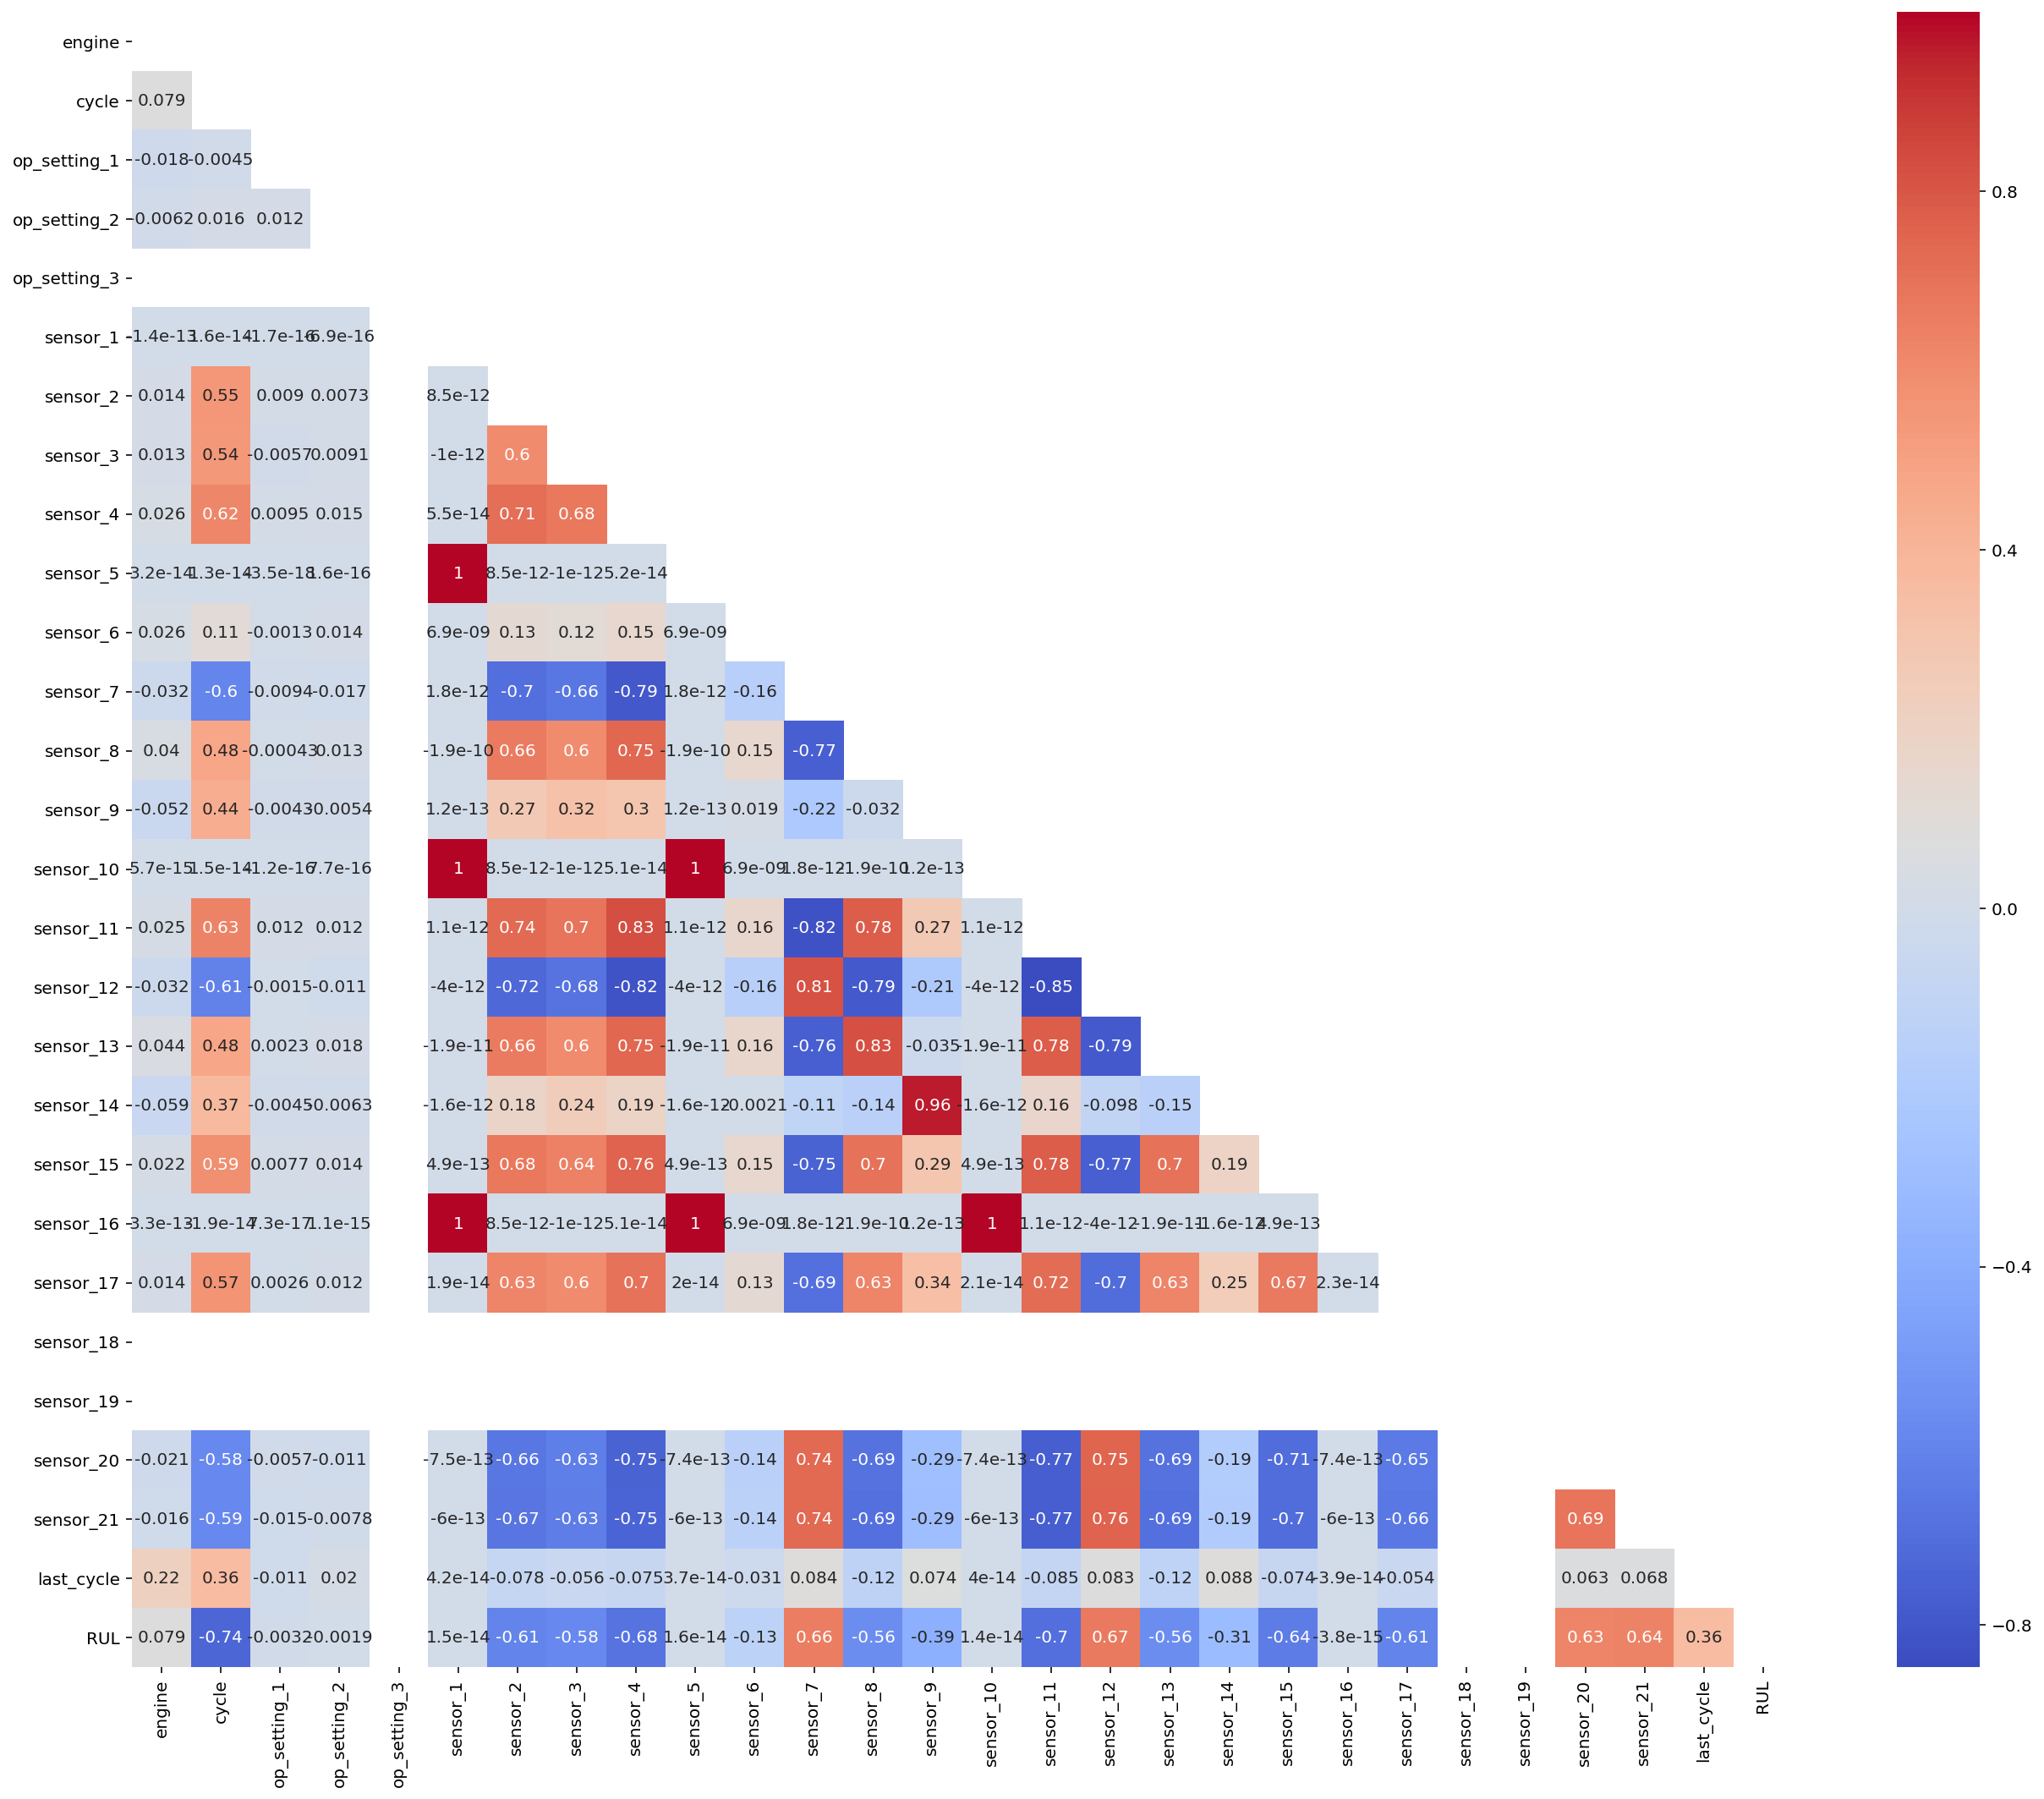

In [25]:
# Plot heatmap for df1_train dataset

heatmap(df1_train_ready)

In [26]:
# Create dataframe for single engine. Use engine number 1.

df_engine1=df1_train_ready[df1_train_ready['engine']==1]

In [27]:
df_engine1.head()

,engine,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,last_cycle,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187


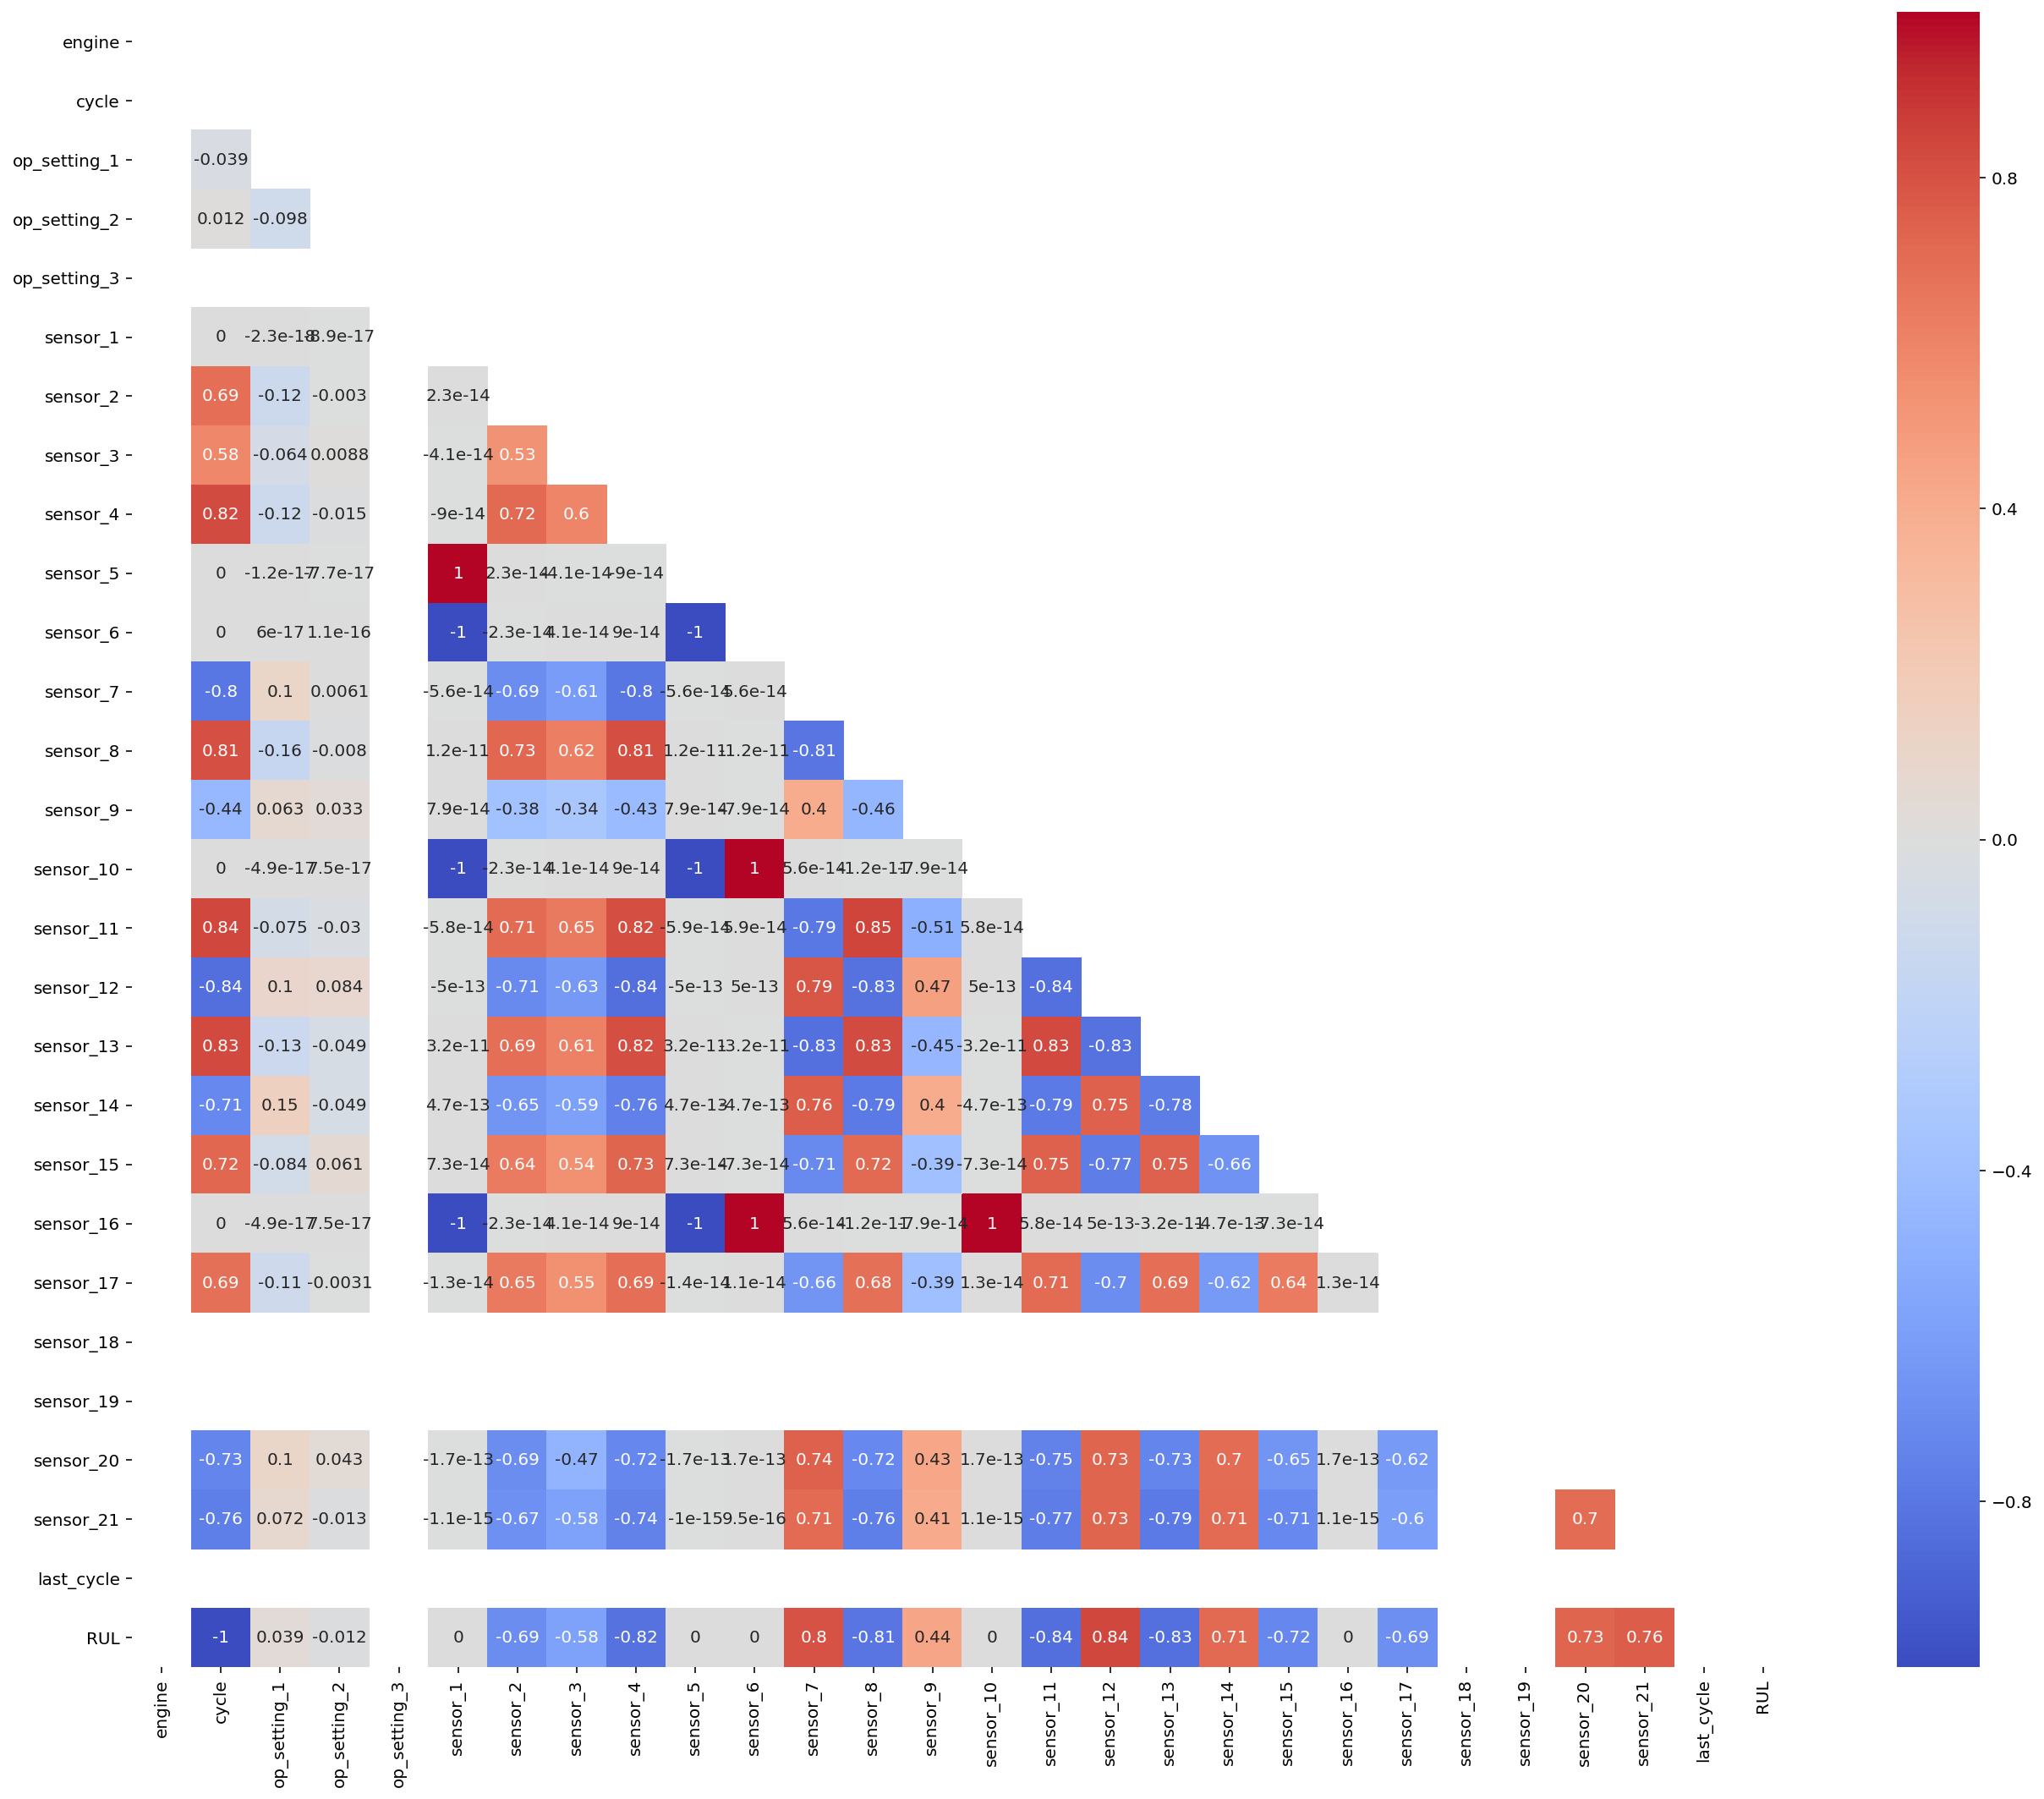

In [28]:
# Plot heatmap of single engine of the train data to see the correlation between features.

heatmap(df_engine1)

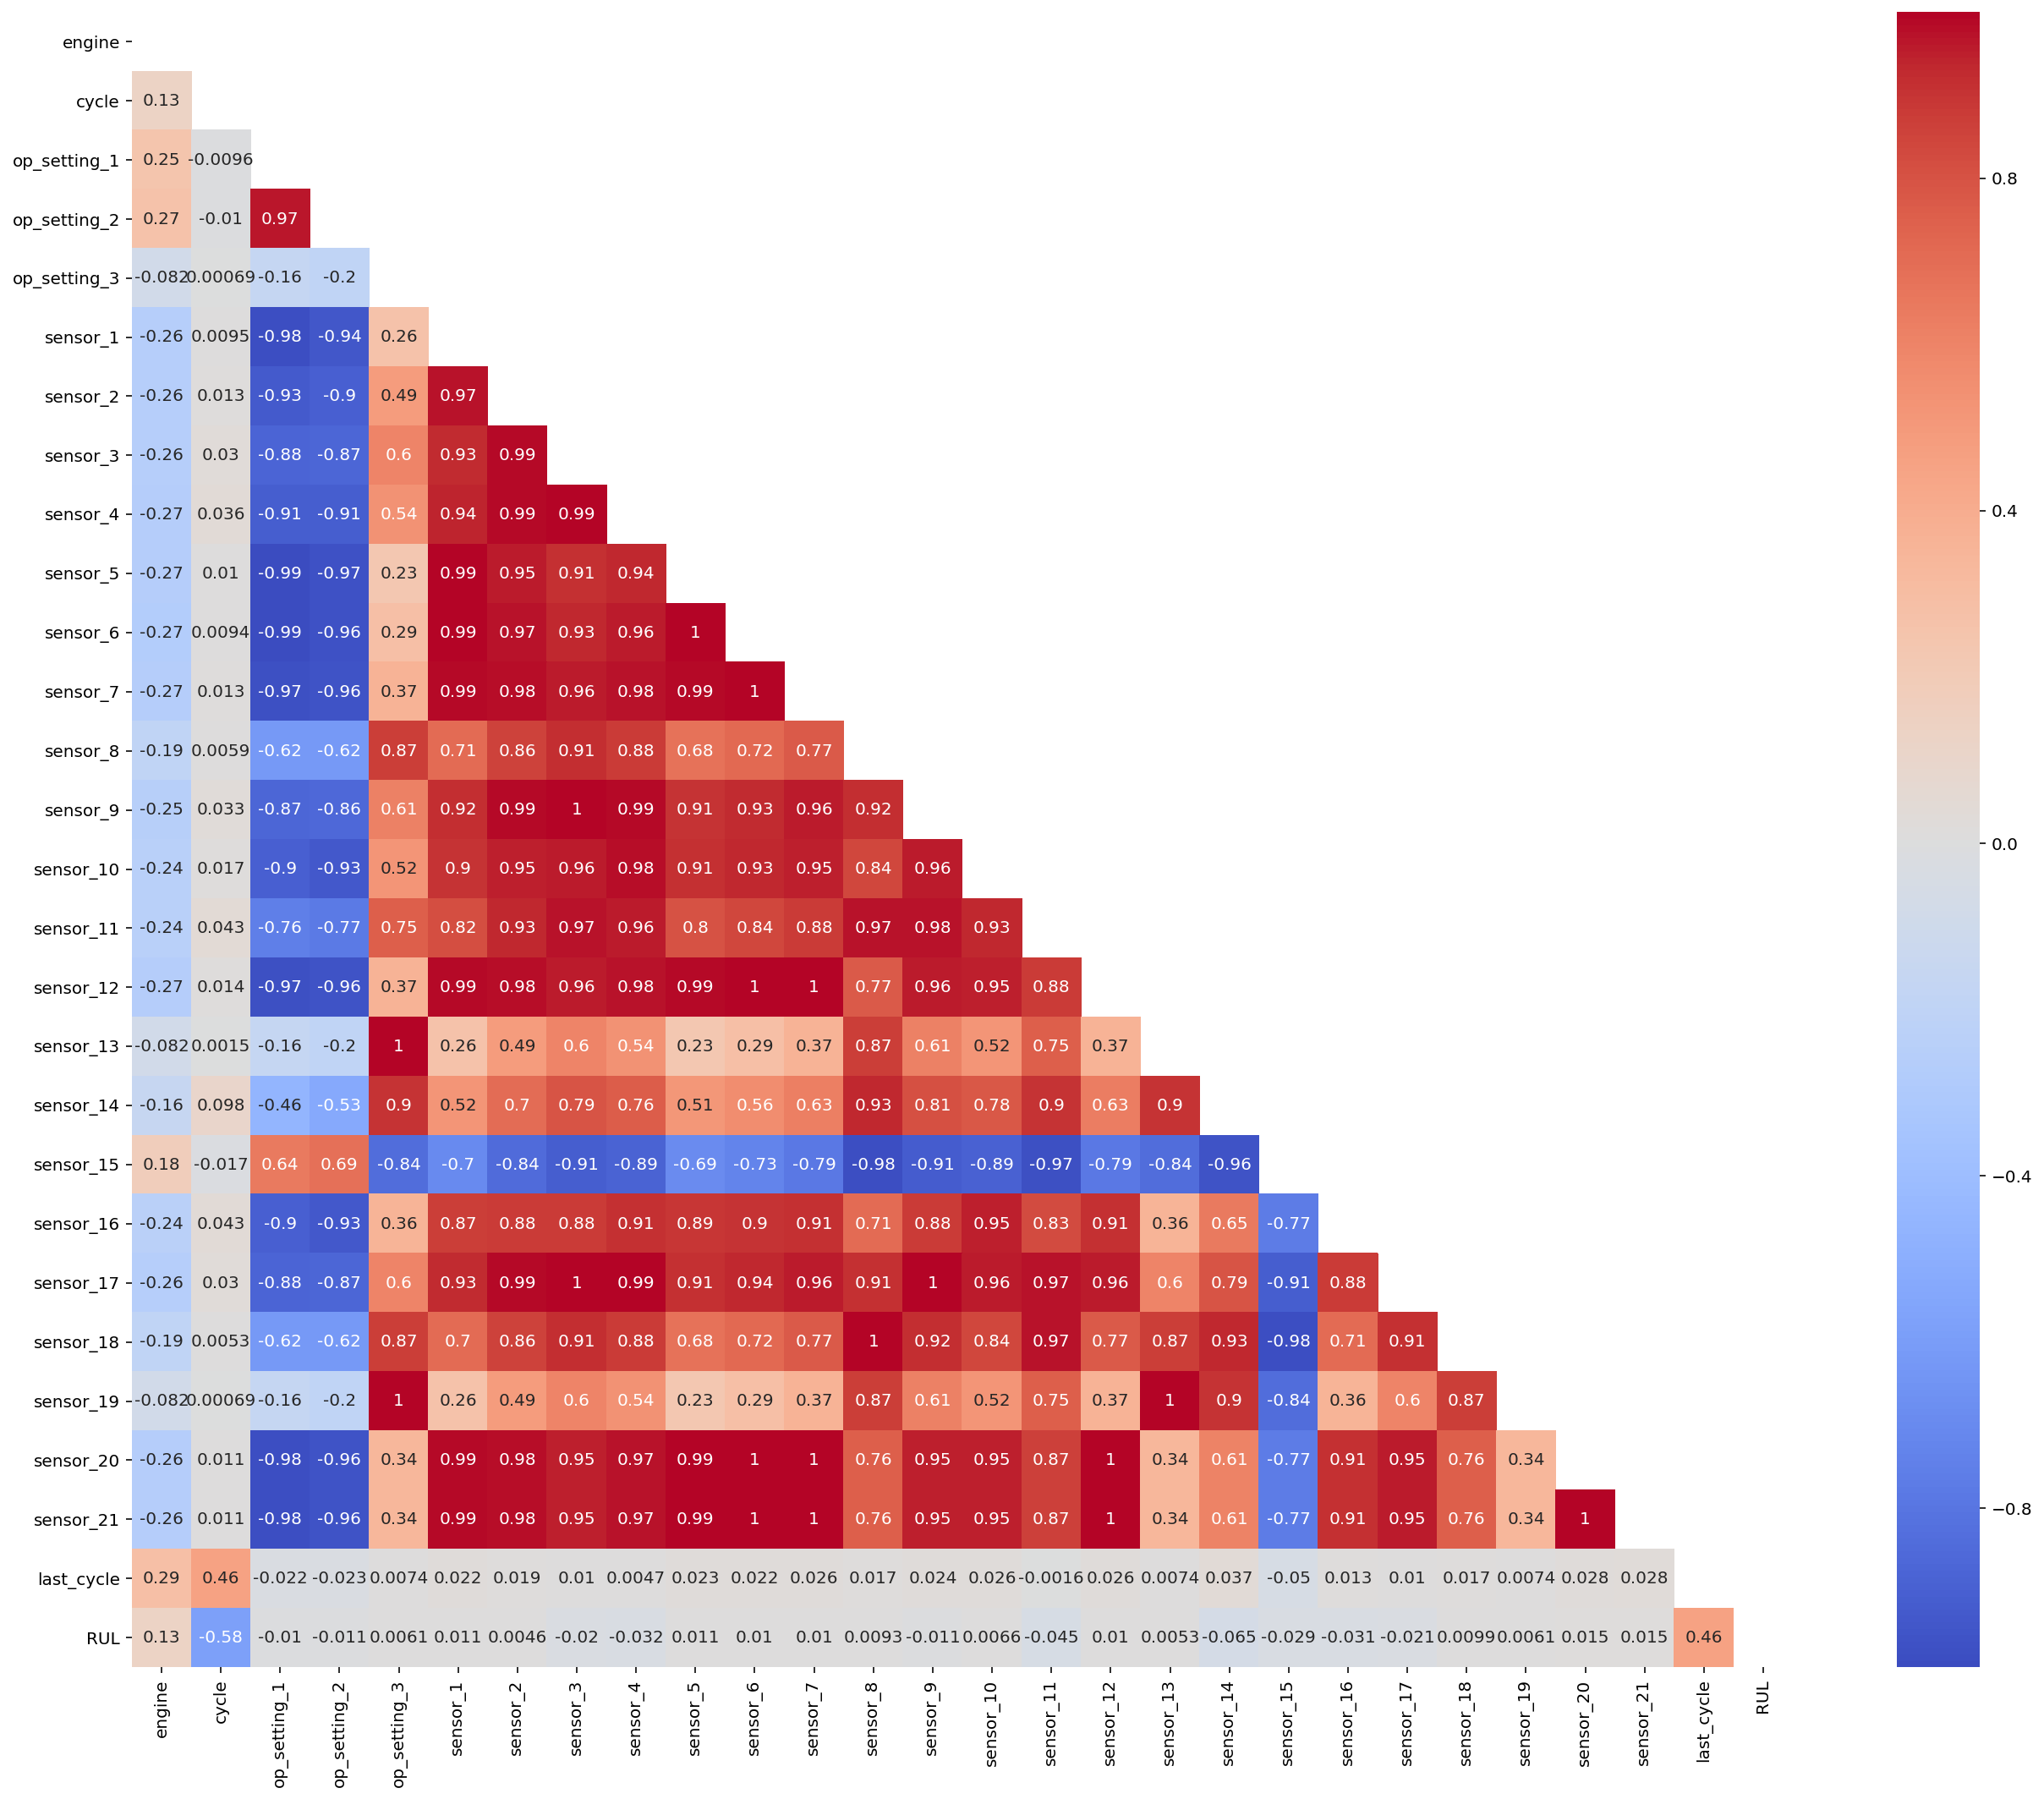

In [29]:
# Plot heatmap of the combined dataset.
# There features are highly correlated compared to the single train dataset #1.

heatmap(df_train_combined)

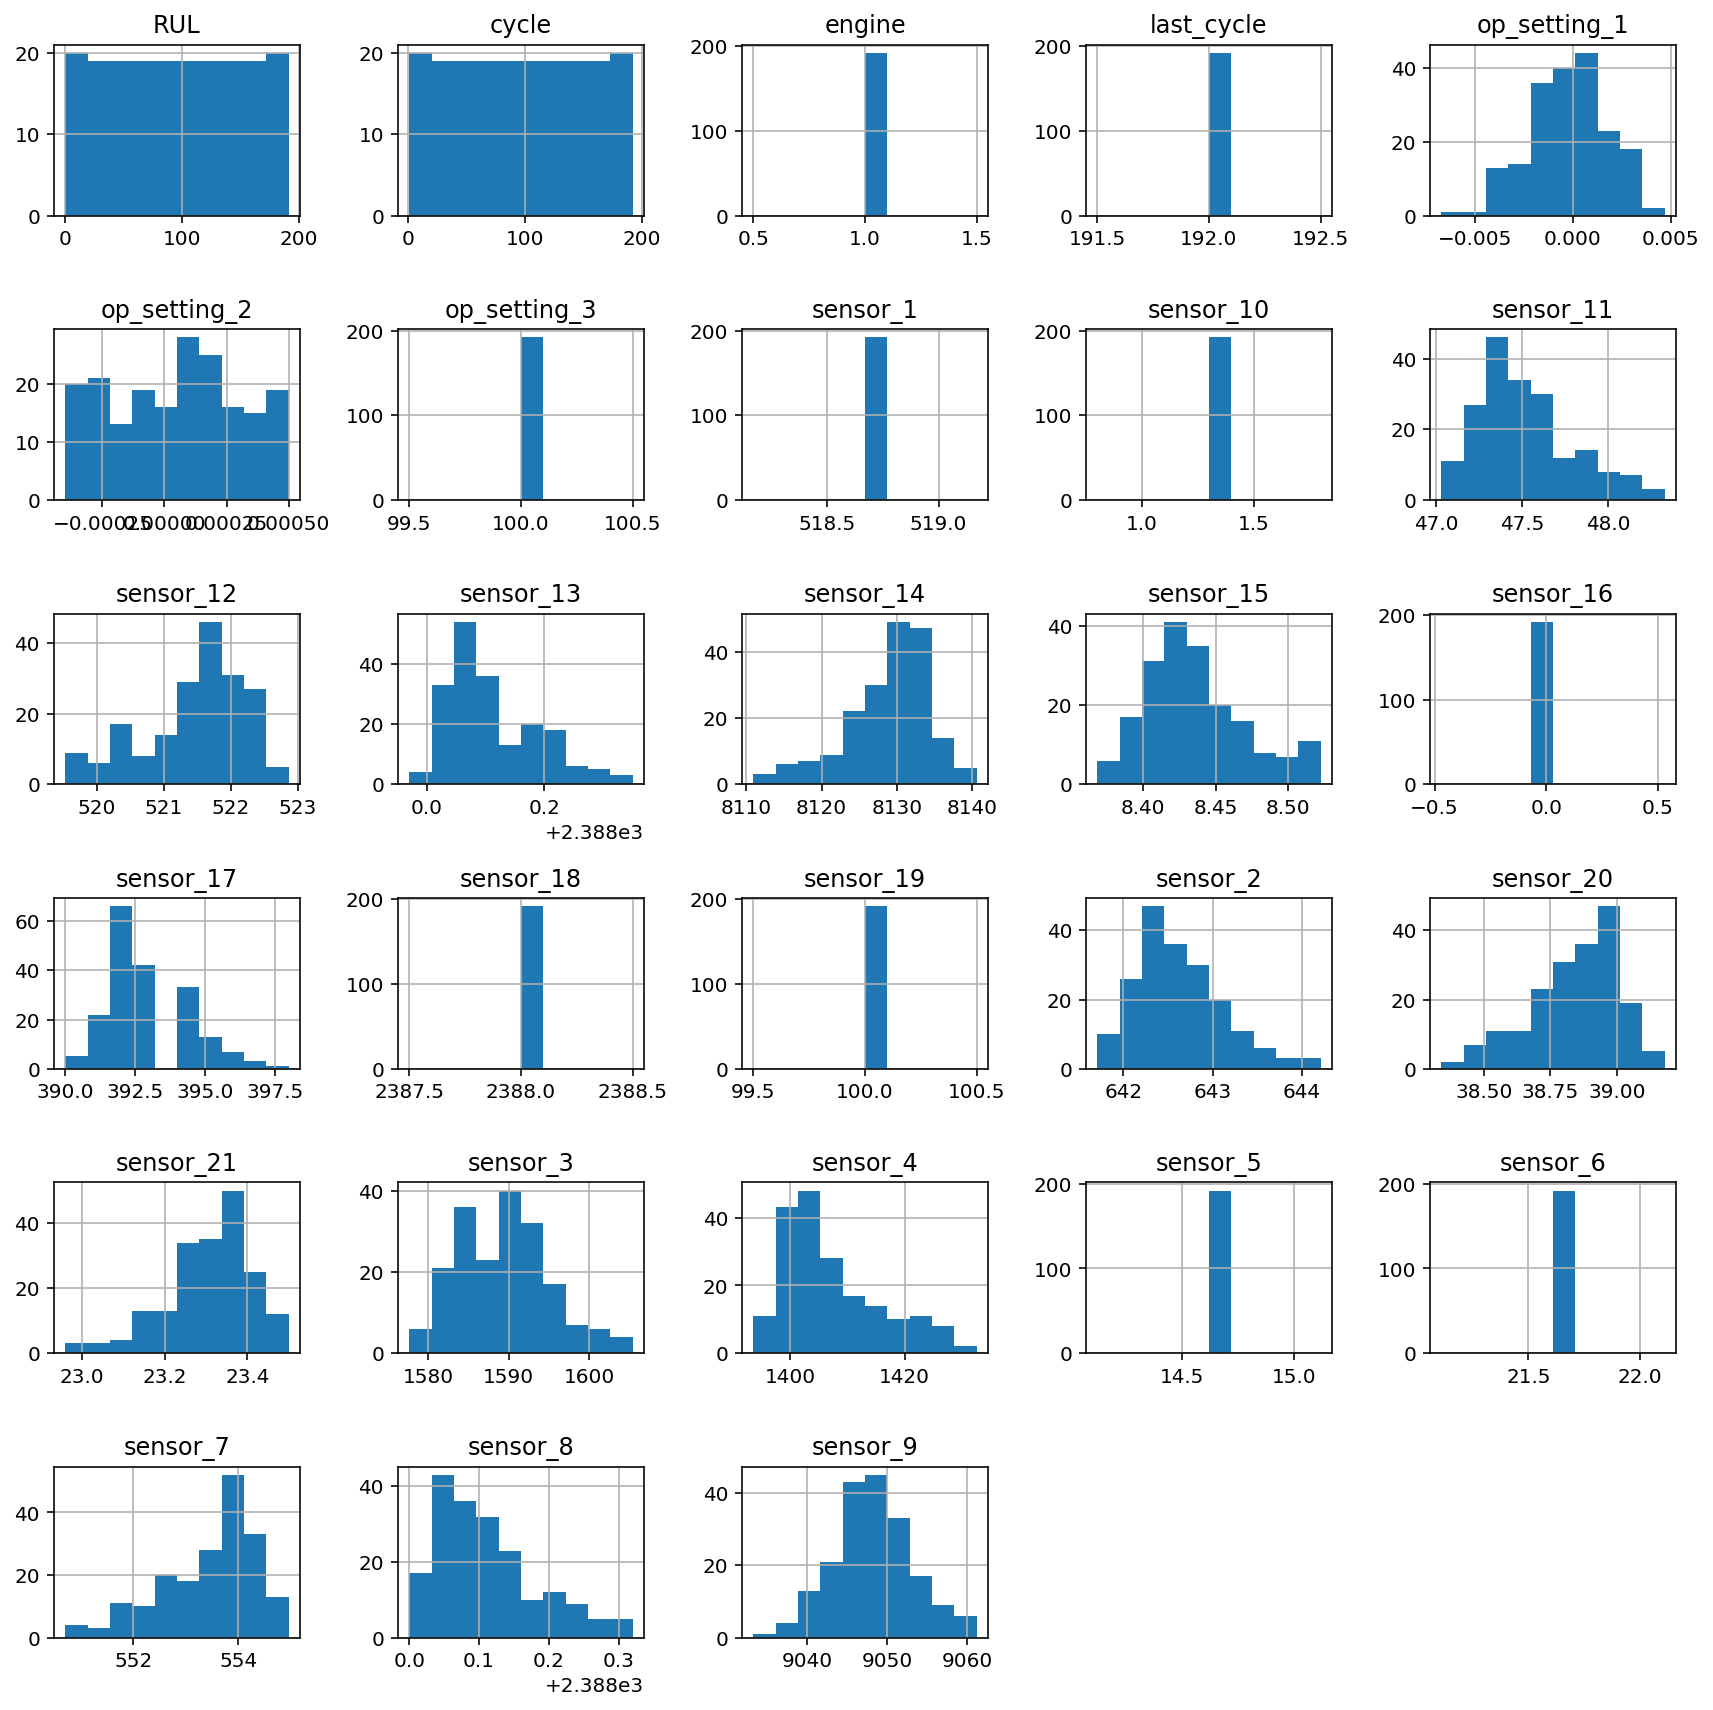

In [30]:
# Distribution plot for single engine

fig = plt.figure(figsize = (12,12))
ax = fig.gca()
df_engine1.hist(ax=ax)
plt.tight_layout()

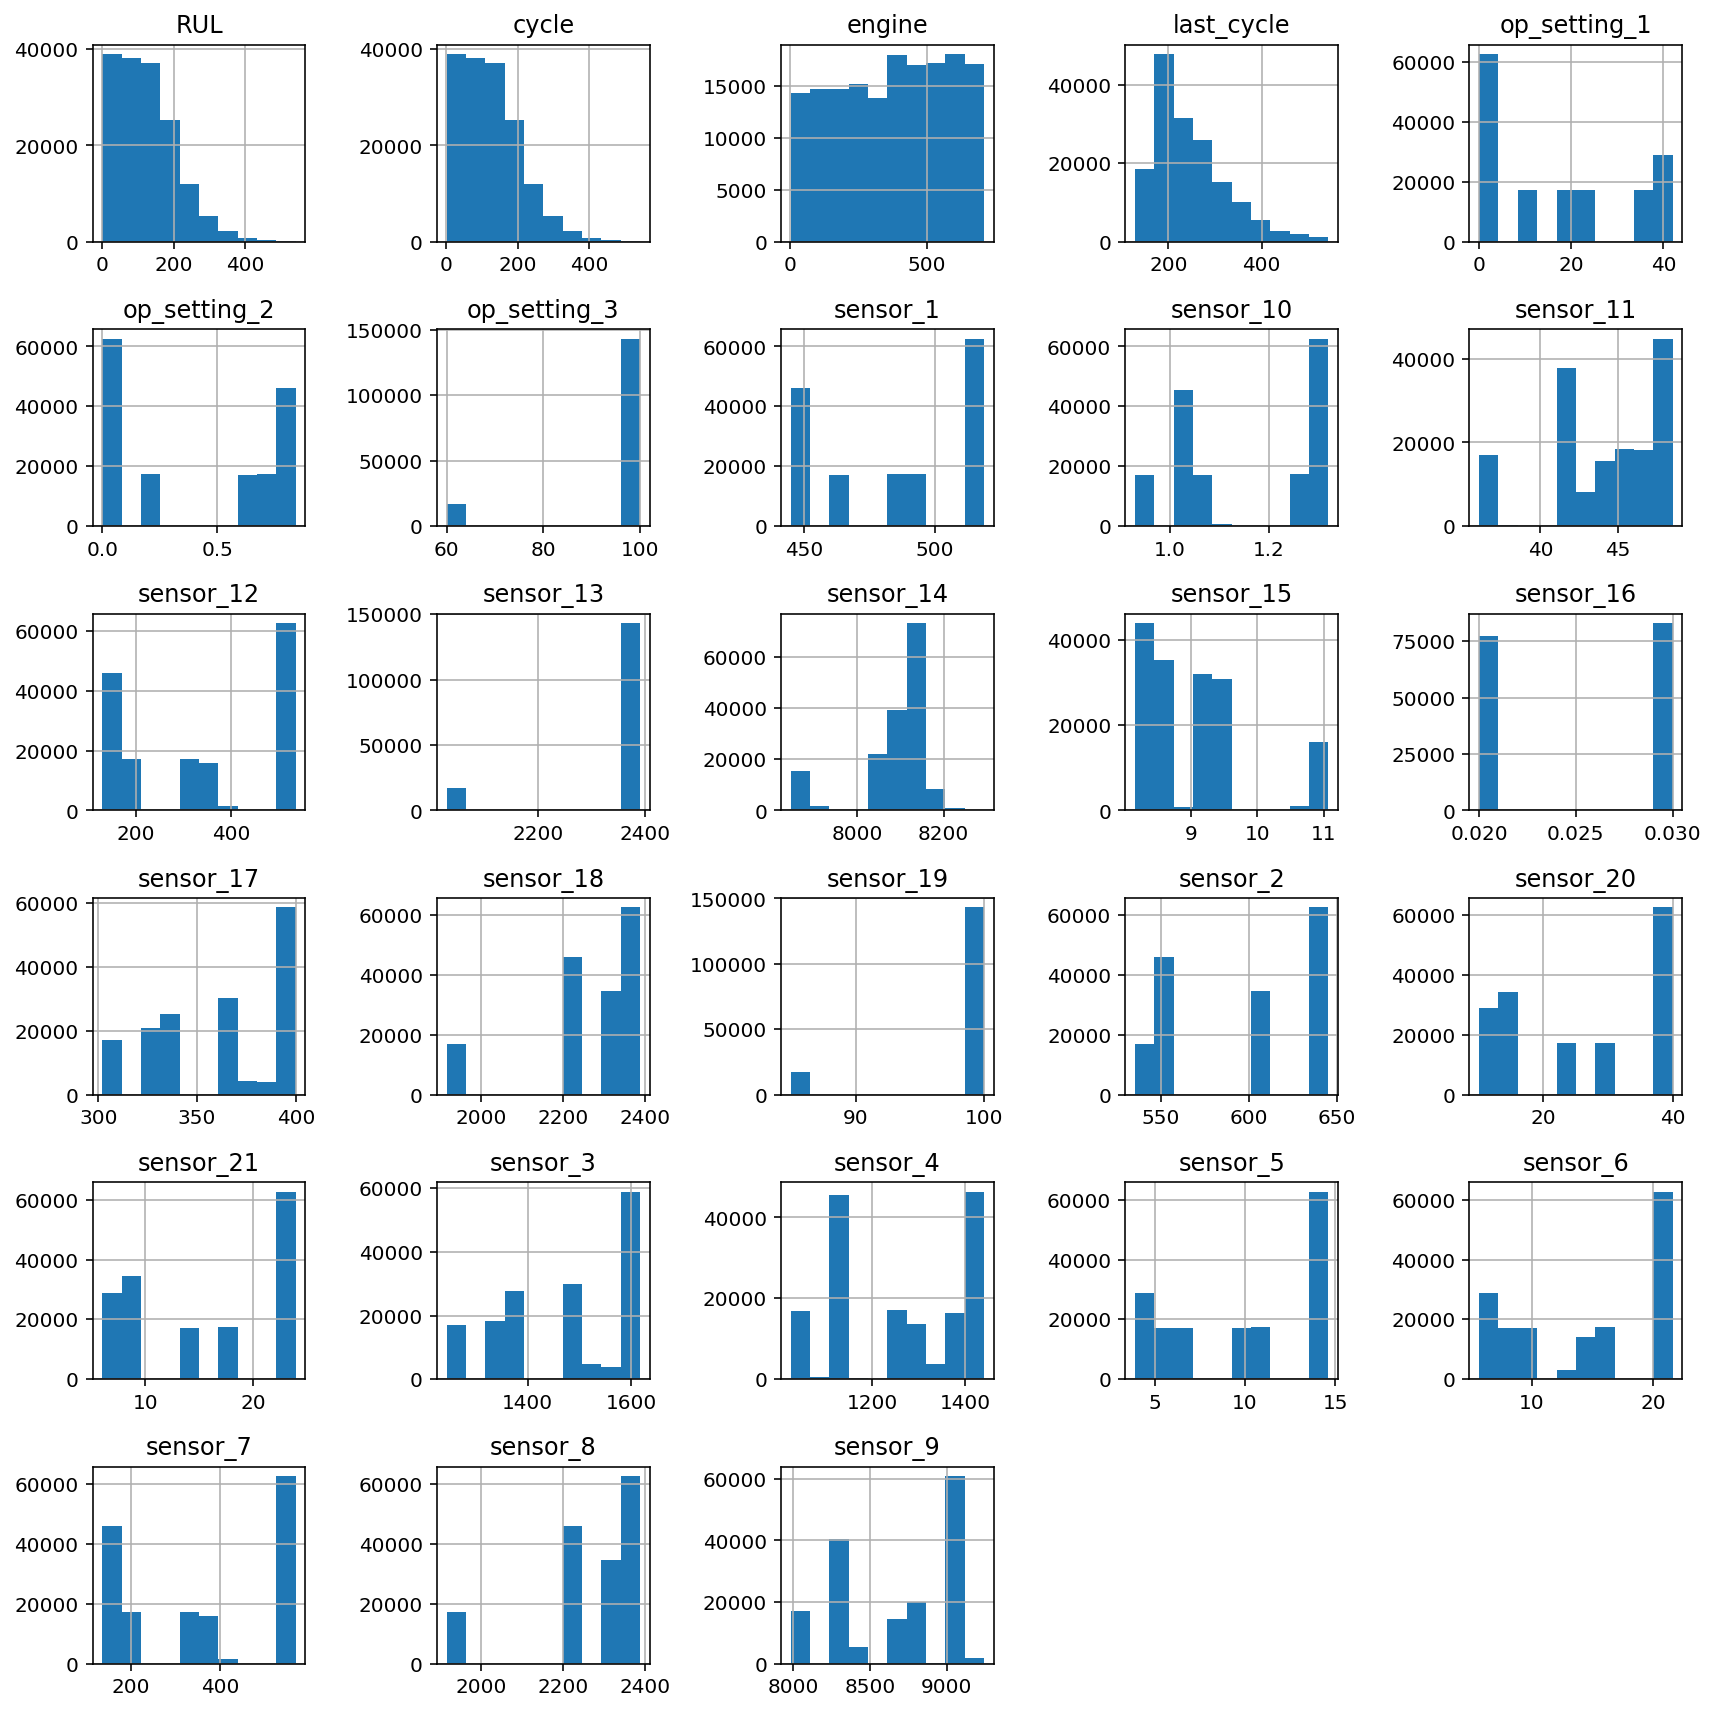

In [31]:
# Distribution plot for all engines

fig = plt.figure(figsize = (12,12))
ax = fig.gca()
df_train_combined.hist(ax=ax)
plt.tight_layout()

### Scale the op_settings and sensors

From the initial EDA, it can be seen that the sensor data ranges from min 0.02 to max 8243. There are also negative values for the op_settings data.  The dataset should thus be normalized using StandardScaler.

The op_setting and sensors can then be plotted against the cycle time to see their trend.

These data from 2 engines (take engine 1 and engine 50 as examples) will be compared to see if they are significantly different.

### Create a function to scale the datasets

In [32]:
# Function to scale the dataset

def scale(df):

    headers=['engine','cycle','op_setting_1','op_setting_2','op_setting_3','sensor_1','sensor_2',
             'sensor_3','sensor_4','sensor_5','sensor_6','sensor_7','sensor_8','sensor_9',
             'sensor_10','sensor_11','sensor_12','sensor_13','sensor_14','sensor_15','sensor_16',
             'sensor_17','sensor_18','sensor_19','sensor_20','sensor_21', 'last_cycle', 'RUL']

    # instantiate StandardScaler()
    ss = StandardScaler() 

    # fit the train set
    temp = ss.fit_transform(df)
    
    
    # After scaling, put the data back into a dataframe

    df_ss = pd.DataFrame(temp)
    df_ss.columns = headers

    # keep back the engine, cycle, last_cycle and RUL values ie don't scale them.
    df_ss['engine'] = df['engine']
    df_ss['cycle'] = df['cycle']
    df_ss['last_cycle'] = df['last_cycle']
    df_ss['RUL'] = df['RUL']
    
    return df_ss

In [33]:
# Scale the training datasets
# The test datasets will be scaled in another function "agg_score" because 
# the test datasets has fewer columns (ie without RUL and last_cycle columns) 
# than the train datasets 

df1_train_ss = scale(df1_train_ready)
df2_train_ss = scale(df2_train_ready)
df3_train_ss = scale(df3_train_ready)
df4_train_ss = scale(df4_train_ready)
df_train_combined_ss = scale(df_train_combined)


In [34]:
# Get engines 1 and 50 normalized data

df_engine1_ss=df1_train_ss[df1_train_ss['engine']==1]

df_engine50_ss=df1_train_ss[df1_train_ss['engine']==50]

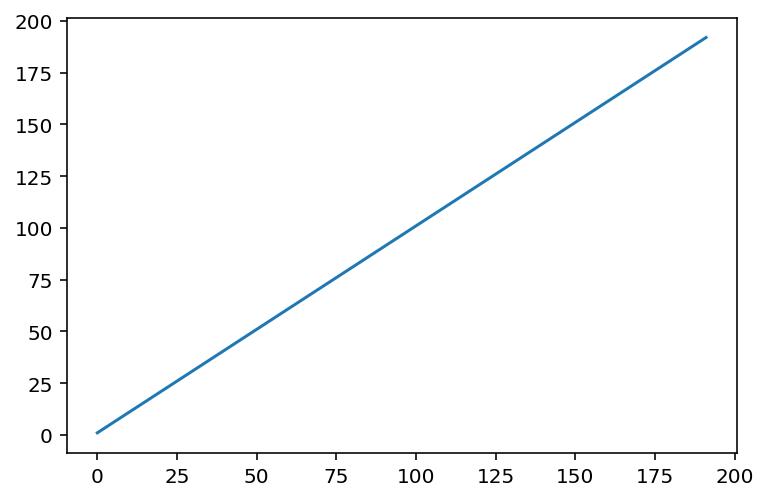

In [35]:
# Plot the cycle

plt.plot(df_engine1['cycle'])

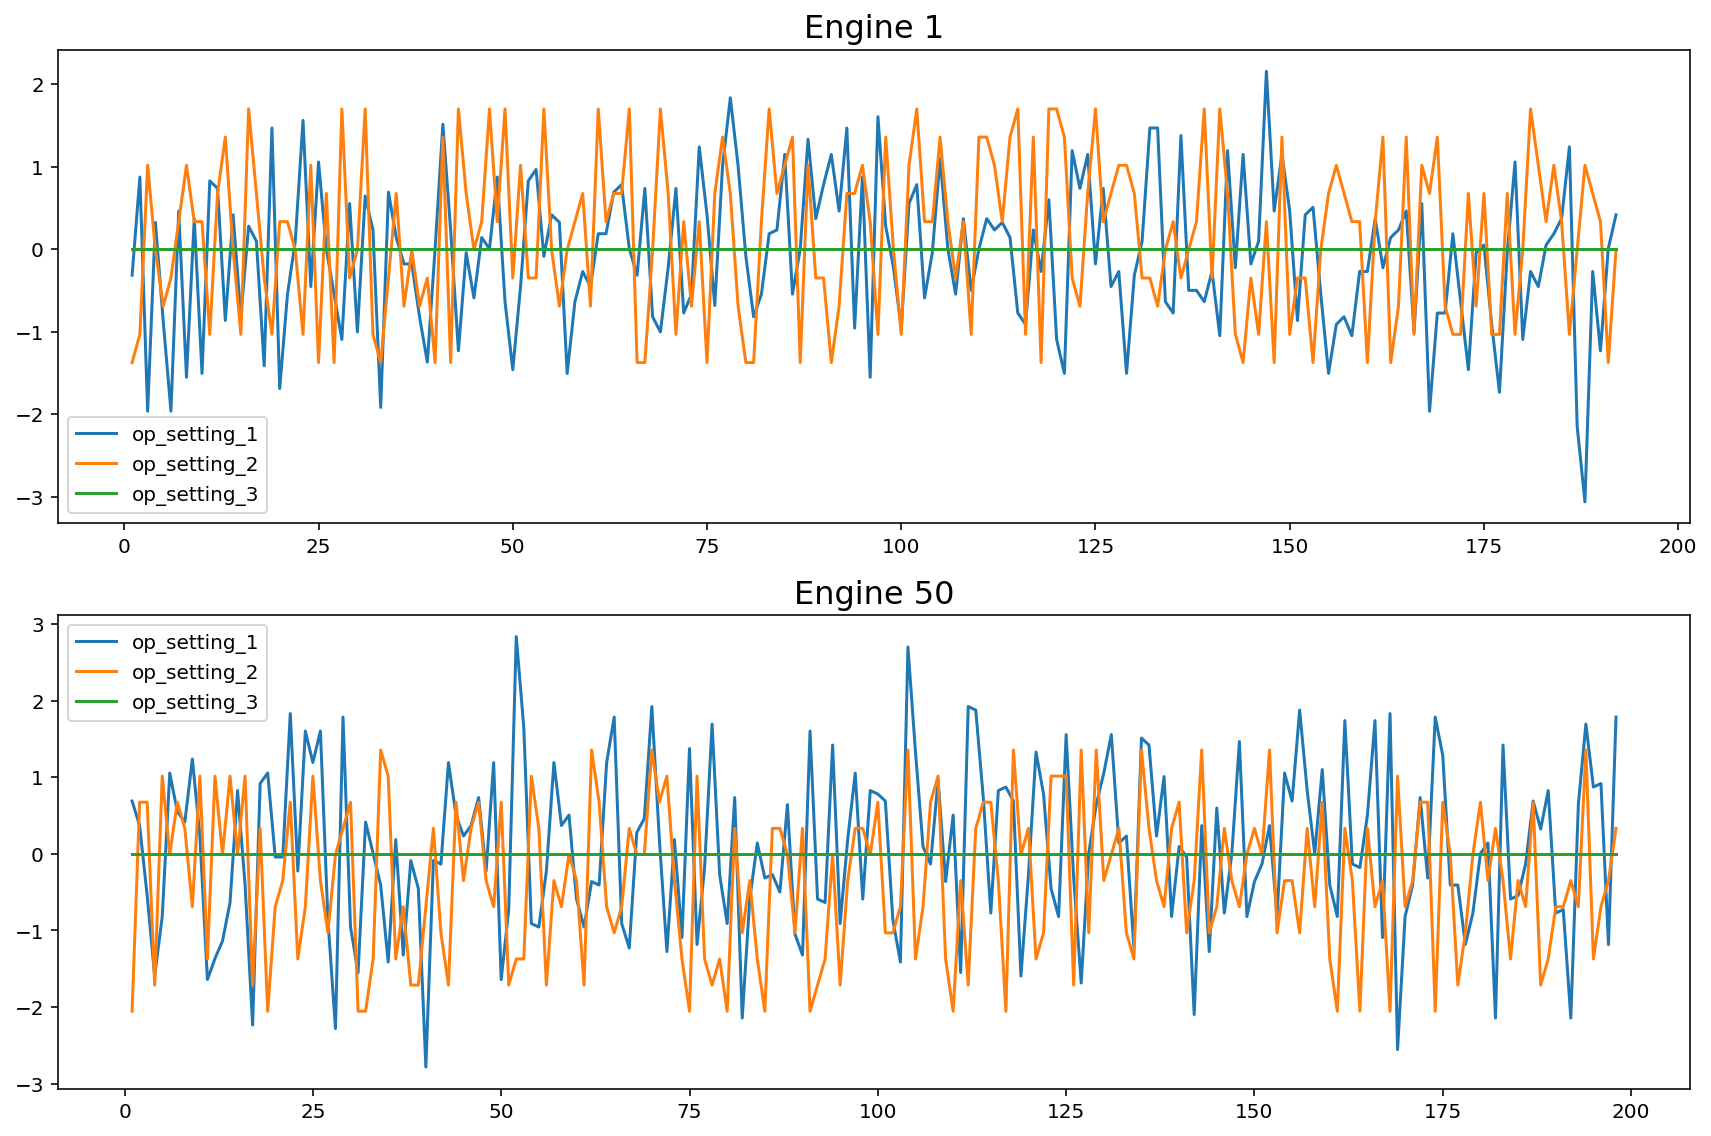

In [36]:
# Plot the op_setting vs cycle

op_setting =['op_setting_1','op_setting_2','op_setting_3']

plt.figure(figsize=(12,8))

for i in op_setting:
    plt.subplot(2,1,1)
    plt.plot(df_engine1_ss['cycle'], df_engine1_ss[i])
plt.legend(op_setting)
plt.title('Engine 1', fontsize=16)

for i in op_setting:
    plt.subplot(2,1,2)
    plt.plot(df_engine50_ss['cycle'], df_engine50_ss[i])
plt.legend(op_setting)
plt.title('Engine 50',fontsize=16)
plt.tight_layout();


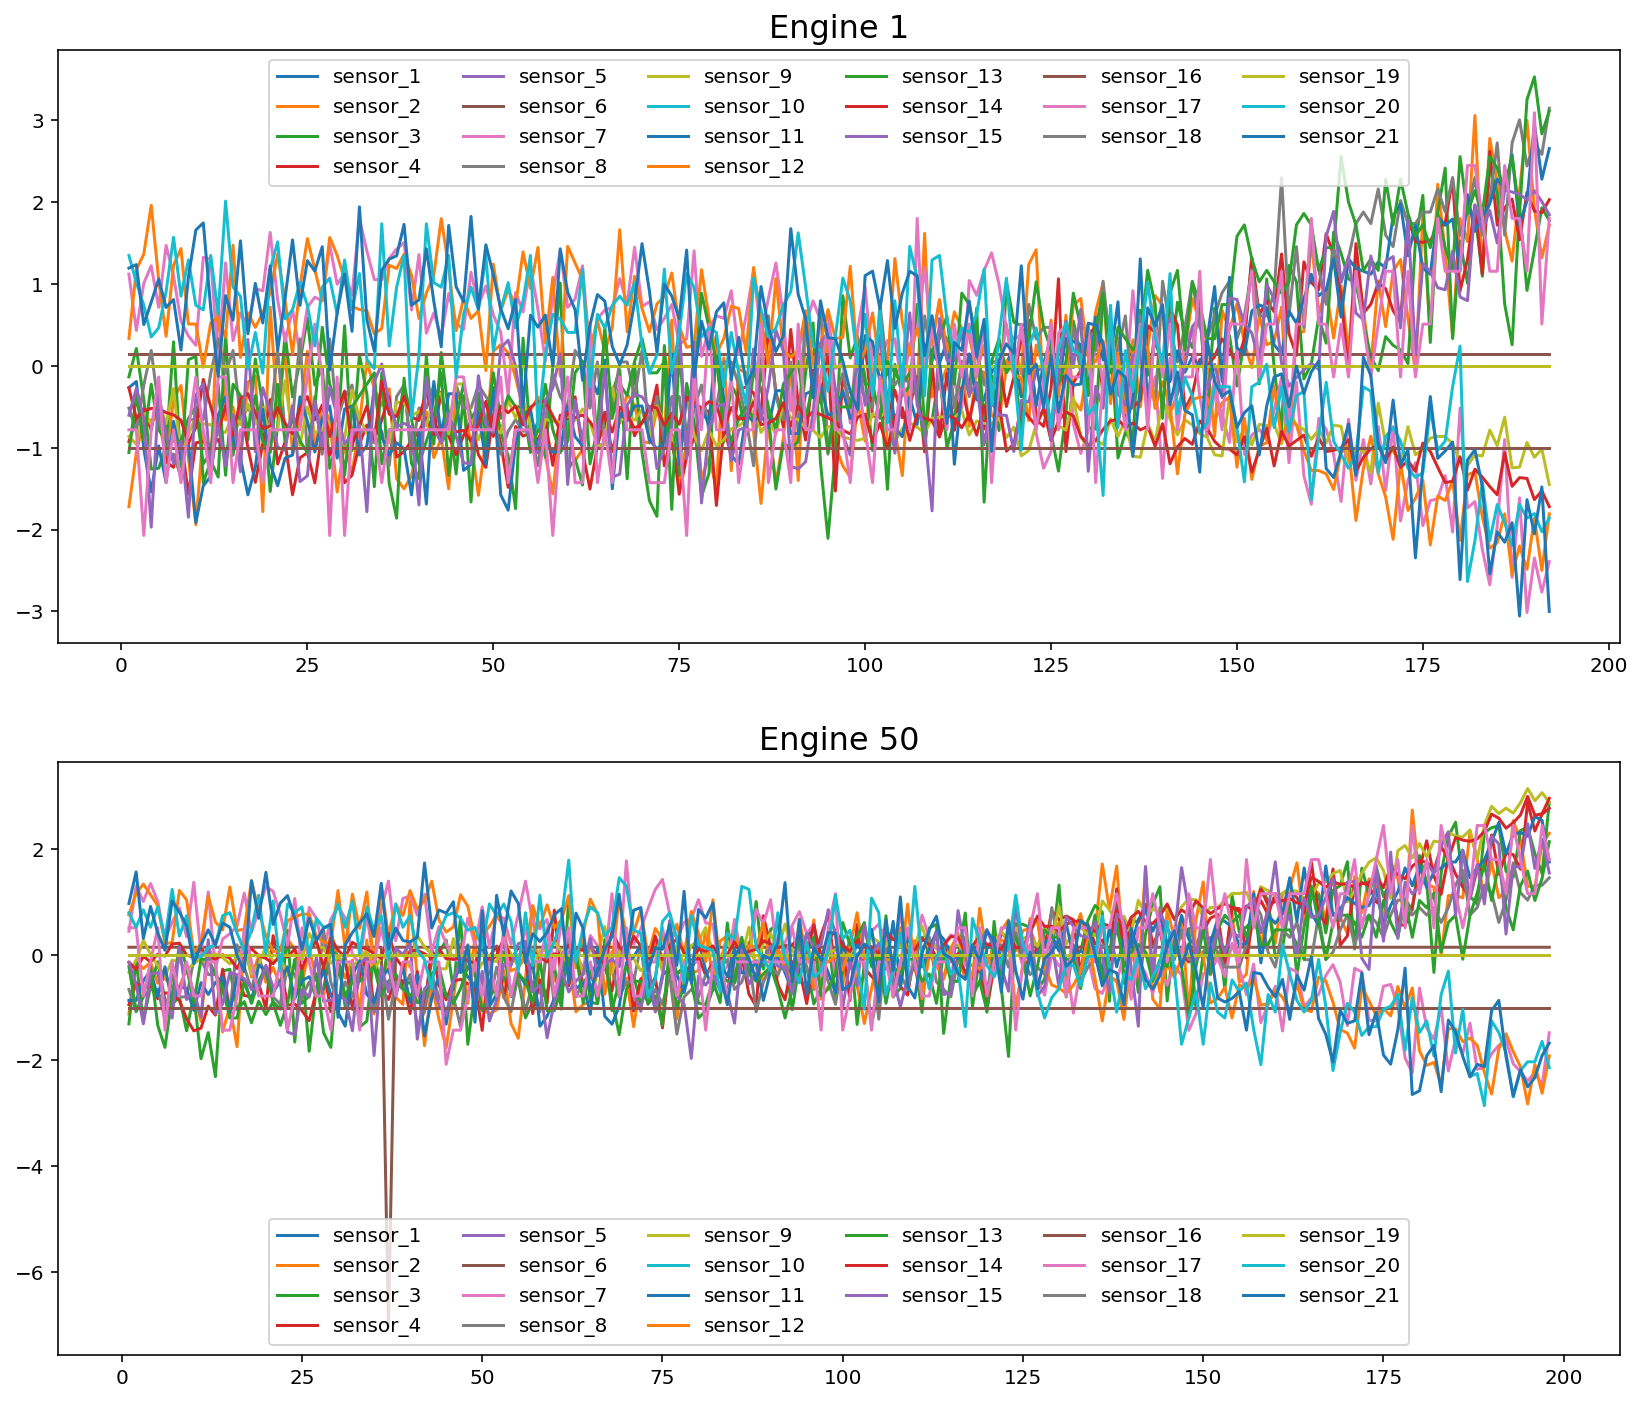

In [37]:
## Plot the sensors vs cycle 

sensors=['sensor_1','sensor_2',
         'sensor_3','sensor_4','sensor_5','sensor_6','sensor_7','sensor_8','sensor_9',
         'sensor_10','sensor_11','sensor_12','sensor_13','sensor_14','sensor_15','sensor_16',
         'sensor_17','sensor_18','sensor_19','sensor_20','sensor_21']

plt.figure(figsize=(14,12))

for i in sensors:
    plt.subplot(2,1,1)
    plt.plot(df_engine1_ss['cycle'], df_engine1_ss[i])
plt.title('Engine 1', fontsize=16)
plt.legend(sensors, loc='upper center', ncol=6)

for i in sensors:
    plt.subplot(2,1,2)
    plt.plot(df_engine50_ss['cycle'], df_engine50_ss[i])
plt.title('Engine 50', fontsize=16)    
plt.legend(sensors, loc='lower center', ncol=6);

There is no clear trend for the op_settings. 

Some of the sensors show a negative trend while some show a positive trend, with the tail ends moving either upwards or downwards.

Some of the sensors data does not seem to change with cycle time. These sensors could potentially be removed in the modelling.

It can be also seen that the data contain noise.

### Create Baseline Regresson Model on Dataset 1 

As this is a regression problem, and there is no naive base score available, a Linear Regression model is constructed to baseline the score, without removing any features or conducting feature engineering.  

Linear, Ridge and Lasso regressions were used and compared. They were tested against the 4 sets of test datasets and Linear Regression was found to have the best aggregate scores among the 3 models :


|Dataset|No. of Engines|No. of Faults and Conditions|Aggregate Score|
|---|---|---|---|
|test_FD001|100|1 Fault, 1 Condition|2128.14|
|test_FD002|259|1 Fault, 6 Conditions|385715.27|
|test_FD003|100|2 Fault, 1 Condition|95660.38|
|test_FD004|248|2 Fault, 6 Condition|320713.00|

The poor scores for the 2nd to 4th test datasets are expected, as the model is only trained on the 1st dataset which has only 1 fault and 1 condition.

As a reference, the NASA top 20 aggregate scores range from 436.84 to 2430.42 for a unseen test set of 435 engines.

In [108]:
# Train-Test-Split

X = df1_train_ss.drop(columns=['last_cycle', 'RUL'])
y = df1_train_ss[['RUL']]

X_train, X_validate, y_train, y_validate = train_test_split(X, y, shuffle = True, random_state = 42 )

In [127]:
# Instantiate Linear Regression, Ridge and Lasso

lr = LinearRegression()
ridge = RidgeCV(alphas=np.logspace(0, 5, 200))
lasso = LassoCV(n_alphas=500)

In [131]:
# Evaluate the 3 models

lr_scores = cross_val_score(lr, X_train, y_train, cv=10)
ridge_scores = cross_val_score(ridge, X_train, y_train, cv=10)
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)

print( 'LR score    : ' , lr_scores.mean())
print( 'Ridge score : ' , ridge_scores.mean())
print( 'Lasso score : ' , lasso_scores.mean())

LR score    :  0.6693845346167643
Ridge score :  0.6694367452971253
Lasso score :  0.6599015529108211


In [132]:
# Fit the 3 models

model_lr = lr.fit(X_train, y_train)
model_ridge = ridge.fit(X_train, y_train)
model_lasso = lasso.fit(X_train, y_train)

In [135]:
# Score the 3 models

score_lr = lr.score(X_validate, y_validate)
score_ridge = ridge.score(X_validate, y_validate)
score_lasso = lasso.score(X_validate, y_validate)
print ('Test Score of LR model    : ', score_lr)
print ('Test Score of Ridge model : ', score_ridge)
print ('Test Score of Lasso model : ', score_lasso)

Test Score of LR model    :  0.6666070200514348
Test Score of Ridge model :  0.6668671378509958
Test Score of Lasso model :  0.6610089103490798


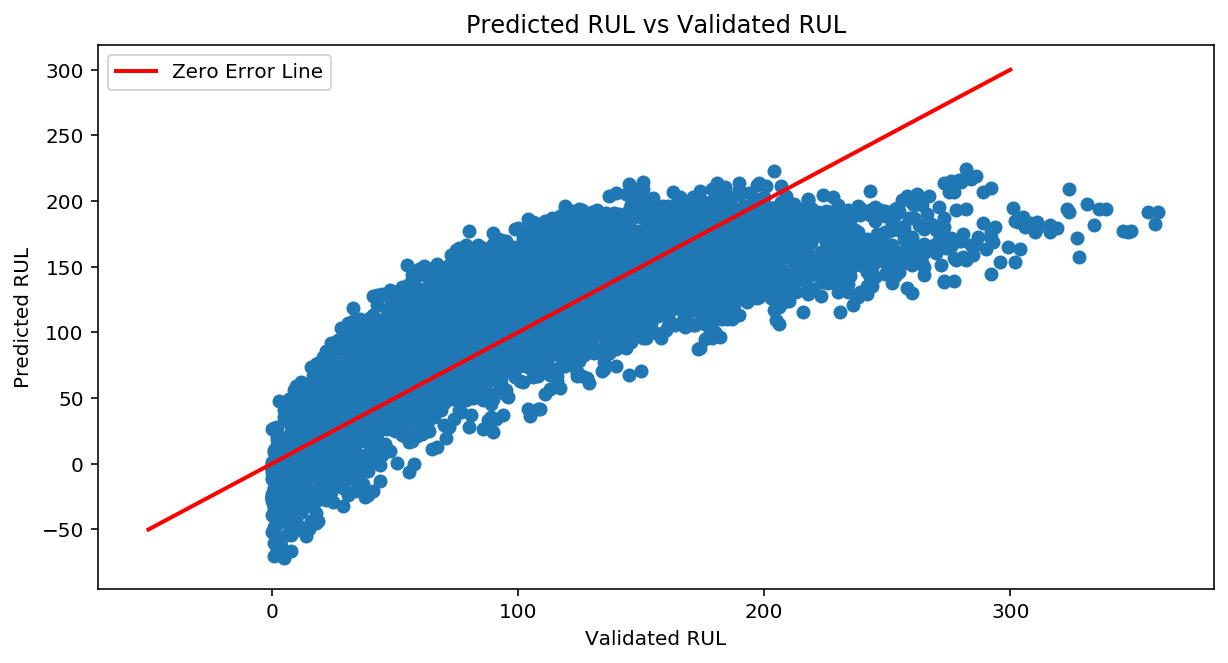

In [153]:
# Plot the yhat vs y_validate 
# The 3 models should have similar graphs since their test scores are very close
yhat_lr = lr.predict(X_validate)
plt.figure(figsize=(10,5))
plt.plot(np.linspace(-50,300,300),np.linspace(-50,300,300), color = 'red', linewidth = 2, label ='Zero Error Line')
plt.scatter(y_validate, yhat_lr)
plt.title('Predicted RUL vs Validated RUL')
plt.xlabel('Validated RUL')
plt.ylabel('Predicted RUL')
plt.legend();

# Plot the residual errors in training and test data

plt.figure(figsize=(12,6))

plt.scatter(lr.predict(X_train), lr.predict(X_train) - y_train, 
            color = 'orange', s = 10, label = 'Train data') 
  
plt.scatter(lr.predict(X_validate), lr.predict(X_validate) - y_validate, 
            color = 'blue', s = 10, label = 'Validate data');

## plotting line for zero residual error 
plt.hlines(y = 0, xmin = -70, xmax = 250, color = 'red', linewidth = 2, label ='Zero Error Line') 

plt.title('Residual Errors') 
plt.legend(loc = 'upper left');

## Aggregated Score for RUL Prediction

The final score is a weighted sum of RUL errors. The scoring function is an asymmetric function that penalizes late predictions more than the early predictions and is expressed by the equation below.  UUT refers to the engine in this project. This scoring metrics is provided by NASA.

<img src="files/scoring%20metrics.png" width="350"/>


In [166]:
# Function to obtain the aggregate score of the model
# Store the score and model as well as a dataframe for easy reference

models = []
scores = []
test_names = []

def agg_score(model, model_name, test_set, test_data, true_rul):
    
    # instantiate StandardScaler()
    ss = StandardScaler() 
    
    # Scale the test data first
    test_ss = ss.fit_transform(test_data)
    
    # predict the RUL
    prediction = model.predict(test_ss)
    
    # create a RUL column for each engine
    test_result = test_data
    test_result['RUL'] = prediction
    test_rul = test_result.groupby('engine', as_index=False)['RUL'].min()
    
    # the RUL column is also created for the test dataset.
    # Remove it to keep the test dataset as orignal.
    test_result.drop(['RUL'], axis=1, inplace = True)
    
    # calculate the aggregate score based on the given formula above
    s = 0
    for i in range(true_rul.shape[0]):
        d = test_rul['RUL'][i] - true_rul['RUL'][i]
        if d <0:
            e = (np.exp(-d/10))-1
            s = s + e
        else:
            e = (np.exp(d/13))-1
            s = s + e
            
    # append the score and model to df
    
    models.append(model_name)
    scores.append(round(s,2))
    test_names.append(test_set)
    return pd.DataFrame({'Model': models, 'Test Set' : test_names, 'Aggregate Score' : scores})
    

In [167]:
# Calculate the LR aggregate score for test datasets

agg_score(lr,'LR', 'dataset #1', df1_test,true_rul1)
agg_score(lr, 'LR','dataset #2', df2_test,true_rul2)
agg_score(lr,'LR', 'dataset #3', df3_test,true_rul3)
agg_score(lr, 'LR', 'dataset #4', df4_test,true_rul4)

,Model,Test Set,Aggregate Score
0,LR,dataset #1,2128.15
1,LR,dataset #2,385715.29
2,LR,dataset #3,95660.40
3,LR,dataset #4,320712.94


In [168]:
# Calculate the Ridge aggregate scores for test datasets

agg_score(ridge,'Ridge', 'dataset #1', df1_test,true_rul1)
agg_score(ridge,'Ridge', 'dataset #2', df2_test,true_rul2)
agg_score(ridge,'Ridge', 'dataset #3', df3_test,true_rul3)
agg_score(ridge,'Ridge', 'dataset #4', df4_test,true_rul4)

,Model,Test Set,Aggregate Score
0,LR,dataset #1,2128.15
1,LR,dataset #2,385715.29
2,LR,dataset #3,95660.40
3,LR,dataset #4,320712.94
4,Ridge,dataset #1,2241.73
5,Ridge,dataset #2,419166.79
6,Ridge,dataset #3,95935.68
7,Ridge,dataset #4,348458.07


In [169]:
# Calculate the Lasso aggregate scores for test datasets

agg_score(lasso,'Lasso', 'dataset #1', df1_test,true_rul1)
agg_score(lasso,'Lasso', 'dataset #2', df2_test,true_rul2)
agg_score(lasso,'Lasso', 'dataset #3', df3_test,true_rul3)
agg_score(lasso,'Lasso', 'dataset #4', df4_test,true_rul4)

,Model,Test Set,Aggregate Score
0,LR,dataset #1,2128.15
1,LR,dataset #2,385715.29
2,LR,dataset #3,95660.40
3,LR,dataset #4,320712.94
4,Ridge,dataset #1,2241.73
5,Ridge,dataset #2,419166.79
6,Ridge,dataset #3,95935.68
7,Ridge,dataset #4,348458.07
8,Lasso,dataset #1,10320.05
9,Lasso,dataset #2,1347258.55


For dataset #1, LR performs the best.
For dataset #2, LR performs the best.
For dataset #3, LR performs the best.
For dataset #4, LR performs the best.

### Create Baseline Regression Model on Dataset #4 For Comparison

Dataset #4 has 248 engines with 2 faults and 6 conditions in the data. Model a baseline Linear Regression against this set of data for comparison against the dataset #1.

<div>
<img src="file:///Users/Dickson/Capstone/NASA%20TurboFan%20Predictive%20Maintenance/scoring%20of%20RUL%20prediction.png" width="500"/>
</div>

<div>
<img src="file:///Users/Dickson/Capstone/NASA%20TurboFan%20Predictive%20Maintenance/scoring%20of%20RUL%20prediction.png" width="500"/>
</div>

In [50]:
# Train-Test-Split

X = df4_train_ss.drop(columns=['last_cycle', 'RUL'])
y = df4_train_ss[['RUL']]

X_train, X_validate, y_train, y_validate = train_test_split(X, y, shuffle = True, random_state = 42 )

In [51]:
model_lr4 = lr.fit(X_train, y_train)

# Score the LR model

score_lr = lr.score(X_validate, y_validate)
print ('R2 Score of LR model : ', score_lr)

R2 Score of LR model :  0.6138062462180741


In [60]:
models = []
scores = []
test_names = []

In [61]:
# Calculate the aggregate score for test dataset 1

agg_score(lr,'LR4', 'dataset #1', df1_test,true_rul1)

/Users/Dickson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


,Model,Test Set,Aggregate Score
0,LR4,dataset #1,inf


In [62]:
agg_score(lr,'LR4', 'dataset #4', df4_test,true_rul4)

,Model,Test Set,Aggregate Score
0,LR4,dataset #1,inf
1,LR4,dataset #4,63188.03


In [66]:
# instantiate StandardScaler()
ss = StandardScaler() 
    
    # Scale the test data first
test_ss = ss.fit_transform(df1_test)
    
    # predict the RUL
prediction = lr.predict(test_ss)
    
    # create a RUL column for each engine
test_result = df1_test
test_result['RUL'] = prediction
test_rul = test_result.groupby('engine', as_index=False)['RUL'].min()
    
    # the RUL column is also created for the test dataset.
    # Remove it to keep the test dataset as orignal.
test_result.drop(['RUL'], axis=1, inplace = True)
    
    # calculate the aggregate score based on the given formula above
s = 0
for i in range(true_rul1.shape[0]):
    d = test_rul['RUL'][i] - true_rul1['RUL'][i]
    if d <0:
        print('-d/10 = ', -d/10)
        e = (np.exp(-d/10))-1
        print(i, e)
        s = round(s + e,2)
    else:
        print('d/13 = ', d/10)
        e = (np.exp(d/13))-1
        s = round(s + e,2)

-d/10 =  78.11813212476392
0 8.438664453335158e+33
-d/10 =  285.028939584598
1 6.116396686003961e+123
-d/10 =  457.55876038999276
2 5.190925355652158e+198
-d/10 =  259.7540004123215
3 6.452515127115099e+112
-d/10 =  308.20113033449974
4 7.080276540189712e+133
-d/10 =  398.68034322819244
5 1.395317712478303e+173
-d/10 =  44.788346430138105
6 2.8270384037548175e+19
-d/10 =  297.55357287343196
7 1.6821889255315893e+129
-d/10 =  287.12680265967276
8 4.984091441917748e+124
-d/10 =  188.50183724833784
9 7.333440042395847e+81
-d/10 =  367.8516804900531
10 5.701051913259695e+159
-d/10 =  129.5125356659134
11 1.764329017848247e+56
-d/10 =  162.97155216127467
12 5.993021156618396e+70
-d/10 =  319.16186302869875
13 4.0760166307659416e+138
-d/10 =  56.542345573733165
14 3.597730902502641e+24
-d/10 =  80.38993340603714
15 8.182847901491393e+34
-d/10 =  226.58223883860722
16 2.5317220545977032e+98
-d/10 =  364.88402865308717
17 2.931704398944492e+158
-d/10 =  86.51563623967422
18 3.7433757036604626e

In [105]:
agg_score(ridge,'Ridge', 'dataset #1', df1_test,true_rul1)


,Model,Test Set,Aggregate Score
0,LR4,dataset #1,inf
1,LR4,dataset #4,63188.03
2,LR,dataset #1,2241.79
3,Ridge,dataset #1,2241.79
